# Example Pipeline for e401k

This notebook is a proof-of-concept for generating causal samples from external samples

In [1]:
import contextlib
import sys
import os
sys.path.append("../")  # go to parent dir
# sys.path.append("../data/analysis/")  # go to parent dir

import jax
import jax.random as jr
import jax.numpy as jnp
# jnp.set_printoptions(precision=2)
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import rankdata

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage

from frugal_flows.causal_flows import independent_continuous_marginal_flow, get_independent_quantiles, train_frugal_flow
from frugal_flows.sample_outcome import sample_outcome
from frugal_flows.sample_marginals import from_quantiles_to_marginal_cont, from_quantiles_to_marginal_discr
from frugal_flows.train_quantile_propensity_score import train_quantile_propensity_score
from frugal_flows.bijections import UnivariateNormalCDF
from frugal_flows.benchmarking import FrugalFlowModel
from frugal_flows.sample_outcome import sample_outcome
from frugal_flows.sample_marginals import from_quantiles_to_marginal_cont, from_quantiles_to_marginal_discr
from frugal_flows.train_quantile_propensity_score import train_quantile_propensity_score
import torch
from benchmarking import compare_datasets


import data.template_causl_simulations as causl_py
import data.analysis.validationMethods as valMethods
import wandb

# Activate automatic conversion of rpy2 objects to pandas objects
pandas2ri.activate()
base = importr('base')
utils = importr('utils')

# Import the R library causl
try:
    causl = importr('causl')
except Exception as e:
    package_names = ('causl')
    utils.install_packages(StrVector(package_names))

seed = 0
N = 2000
B = 50
sampling_size = 1000
keys, *subkeys = jr.split(jr.PRNGKey(seed), 20)

def clean_ate(value):
    if isinstance(value, (list, tuple, np.ndarray)):
        return np.mean(value)
    return value

In [3]:
marginal_hyperparam_dict = {
    'learning_rate': 5e-4,
    # 'learning_rate': 0.2,
    'RQS_knots': 8,
    'flow_layers': 3,
    'nn_depth': 5,    
    'nn_width': 10,
    'max_patience': 100,
    'max_epochs': 20000
}
hyperparam_dict = {
    'learning_rate': 0.00261635,
    'RQS_knots': 5,
    'flow_layers': 2,
    'nn_depth': 3,    
    'nn_width': 34,
    'max_patience': 100,
    'max_epochs': 20000
}
causal_margin_hyperparams_dict = {
    'RQS_knots': 4,
    'flow_layers': 8,
    'nn_depth': 10,    
    'nn_width': 50,
}
seed=7

# Load data
e401k = pd.read_csv('../data/filtered_401k_data.csv')

# Preprocess data
outcome_col = 'net_tfa'
treatment_col = 'e401'
standardised_outcome_col = f'{outcome_col}_standardised'
Y_control = e401k.loc[e401k[treatment_col]==0, outcome_col]
Y_control_mean = Y_control.mean()
Y_control_std = Y_control.std()
e401k[standardised_outcome_col] = (e401k[outcome_col] - Y_control_mean) / Y_control_std
e401k_filtered = e401k.loc[(e401k[standardised_outcome_col] > -2) & (e401k[standardised_outcome_col] < +3)]
X = jnp.array(e401k_filtered[treatment_col].values)[:, None]
Y = jnp.array(e401k_filtered[standardised_outcome_col].values)[:, None]
covariate_colnames = [col for col in e401k_filtered.columns if col not in [outcome_col,standardised_outcome_col, treatment_col]]
# ['age', 'inc', 'educ', 'fsize', 'marr', 'twoearn', 'db', 'pira', 'hown', 'p401']

cont_columns = ['age', 'inc']
disc_columns = ['educ', 'fsize', 'marr', 'twoearn', 'db', 'pira', 'hown', 'p401']
disc_columns = cont_columns + disc_columns
cont_columns = []

for col in cont_columns:
    mean = e401k_filtered[col].mean()
    std = e401k_filtered[col].std()
    e401k_filtered[col] = (e401k_filtered[col] - mean) / std

Z_cont = jnp.array(e401k_filtered[cont_columns].values).astype(float)
Z_cont = None
# Z_disc = jnp.array(e401k_filtered[disc_columns].values)
Z_disc = jnp.array(e401k_filtered[disc_columns].values)
e401k_rescaled = e401k_filtered[
    [standardised_outcome_col, treatment_col] + covariate_colnames
]

true_ATE = 1000
benchmark_flow = FrugalFlowModel(Y=Y, X=X, Z_disc=Z_disc, Z_cont=Z_cont, confounding_copula=None)

In [4]:
benchmark_flow.train_benchmark_model(
    training_seed=jr.PRNGKey(seed),
    marginal_hyperparam_dict=marginal_hyperparam_dict,
    frugal_hyperparam_dict=hyperparam_dict,
    causal_model='location_translation',
    causal_model_args={'ate': 0, **causal_margin_hyperparams_dict},
    prop_flow_hyperparam_dict=causal_margin_hyperparams_dict
)

 23%|██████████████████████▎                                                                          | 23/100 [00:19<01:04,  1.19it/s, train=-0.04360028593844063, val=-0.04727477332737747 (Max patience reached)]


In [5]:
def rescale_outcome(x, mean, std):
    return x * std + mean

### Unconfounded Data

In [7]:
sim_data_df = benchmark_flow.generate_samples(
    key=jr.PRNGKey(10*seed),
    sampling_size=1000,
    copula_param=0.,
    outcome_causal_model='location_translation',
    outcome_causal_args={'ate': true_ATE / Y_control_std},
    with_confounding=True
)
sim_data_df.columns = e401k_rescaled.columns

(1000, 10)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.


Text(0.5, 1.0, 'Generated e401k Data')

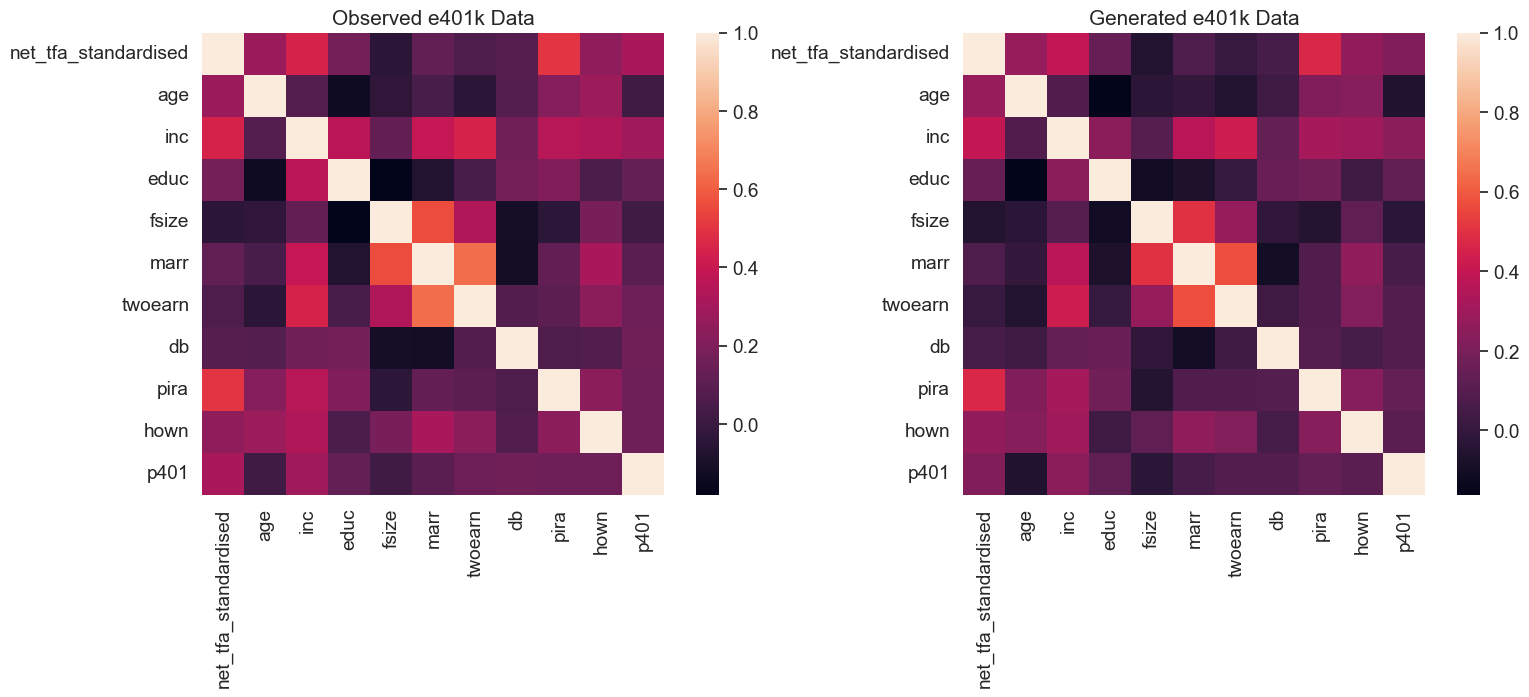

In [9]:
import seaborn as sns

sns.set(font_scale=1.25)
fig,ax = plt.subplots(ncols=2,figsize=(18,6))
sns.heatmap(e401k_rescaled[[standardised_outcome_col] + covariate_colnames].corr(),ax=ax[0],square=True)
ax[0].set_title('Observed e401k Data')
sns.heatmap(sim_data_df[[standardised_outcome_col] + covariate_colnames].corr(),ax=ax[1],square=True)
ax[1].set_title('Generated e401k Data')
# fig.savefig('Lalonde_NSW_0_1000_0.png')

In [10]:
%%time
import torch
from torch_two_sample import MMDStatistic, EnergyStatistic, FRStatistic, KNNStatistic

n_real = e401k_rescaled.shape[0]
n_synth = sim_data_df.shape[0]

# Convert to torch tensors
real_samples_var = torch.tensor(e401k_rescaled.values, dtype=torch.float32)
synth_samples_var = torch.tensor(sim_data_df.values, dtype=torch.float32)

# Initialize test statistics
alphas = [0.1]
mmd = MMDStatistic(n_real, n_synth)
mmd_matrix = mmd(real_samples_var, synth_samples_var, alphas, ret_matrix=True)[1]
print(mmd.pval(mmd_matrix, n_permutations=1000))

0.9959999918937683
CPU times: user 5min 31s, sys: 3.16 s, total: 5min 34s
Wall time: 5min 31s


In [13]:
alphas = [0.1, 0.5, 1.0, 2.0]
k = 3
compare_datasets(e401k_rescaled.values, sim_data_df.values, alphas=alphas, k=3, n_permutations=1000)

Calculating Metrics...
MMD Calculated in 0.7800 seconds...
Energy Calculated in 0.3546 seconds...
FR Calculated in 98.0747 seconds...
KNN Calculated in 6.9110 seconds...
Total Metrics Calculation Time: 106.1213 seconds


{'MMD pval': 0.9909999966621399,
 'Energy pval': 0.0,
 'Friedman-Rafsky pval': 0.0,
 'kNN pval': 1.0}